In [66]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [67]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [50]:
pip install pydot


  Obtaining dependency information for pydot from https://files.pythonhosted.org/packages/7f/90/c9b51f3cdff89cd8f93382060330f43d1af098a6624cff439e700791e922/pydot-2.0.0-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [53]:
!pip install graphviz




[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, concatenate, Layer
from tensorflow.keras.datasets import mnist
from qiskit import Aer, execute
from qiskit.circuit import ParameterVector, QuantumCircuit

# Load and preprocess data
def load_and_preprocess_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # Filter for digits 0 and 1
    train_filter = np.isin(y_train, [0, 1])
    test_filter = np.isin(y_test, [0, 1])
    x_train, y_train = x_train[train_filter], y_train[train_filter]
    x_test, y_test = x_test[test_filter], y_test[test_filter]

    x_train = np.expand_dims(x_train, -1) / 255.0
    x_test = np.expand_dims(x_test, -1) / 255.0
    return x_train, y_train, x_test, y_test

def generate_spikes(image, rate=5, duration=10):
    # Define the duration for spike generation
    time_steps = np.linspace(0, 1, duration)
    # Initialize the spike array with the same spatial dimensions as the image but with an added time dimension
    spikes = np.zeros((image.shape[0], image.shape[1], duration))
    
    # Generate spikes for each pixel over the duration
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            lam = image[i, j] * rate  # Lambda for Poisson distribution based on pixel intensity
            spikes[i, j, :] = np.random.poisson(lam=lam, size=duration)
    
    return spikes, time_steps

def encode_quantum_features(spikes, time_steps, num_qubits=5, shots=1024):
    simulator = Aer.get_backend('aer_simulator')
    params = ParameterVector('theta', 2 * num_qubits)
    features = []

    for t in range(spikes.shape[2]):  # Loop over each time step
        qc = QuantumCircuit(num_qubits)
        param_binds = {}
        for i in range(num_qubits):
            amplitude = spikes[i % spikes.shape[0], i % spikes.shape[1], t]  
            time_encoded = time_steps[t] * 2 * np.pi  # Temporal encoding
            param_binds[params[2 * i]] = amplitude * np.pi  # Amplitude modulation
            param_binds[params[2 * i + 1]] = time_encoded  # Time modulation

            
            qc.rx(params[2 * i], i)
            qc.rz(params[2 * i + 1], i)

        qc.measure_all()

        # Bind parameters and execute the circuit
        compiled_circuit = qc.bind_parameters(param_binds)
        job = execute(compiled_circuit, simulator, shots=shots)
        result = job.result()
        counts = result.get_counts(compiled_circuit)
        feature_vector = np.array([counts.get(bin(j)[2:].zfill(num_qubits), 0) for j in range(2**num_qubits)])
        features.append(feature_vector / np.sum(feature_vector))

    # Flatten features across all time steps
    return np.array(features).flatten()

class ProbabilisticSwitch(Layer):
    def __init__(self, switch_probability=0.5, **kwargs):
        super(ProbabilisticSwitch, self).__init__(**kwargs)
        self.switch_probability = switch_probability

    def call(self, inputs):
        feature1, feature2 = inputs
        random_val = tf.random.uniform([])
        return tf.cond(
            random_val < self.switch_probability,
            lambda: feature1,
            lambda: feature2
        )

def build_hybrid_model(image_input_shape, quantum_features_shape, switch_probability=0.5):
    # Quantum input branch
    quantum_input = Input(shape=(quantum_features_shape,), name="quantum_input")
    q = Dense(128, activation='relu')(quantum_input)
    q = Dropout(0.5)(q)
    q = Dense(64, activation='relu')(q)
    q = Dropout(0.5)(q)
    quantum_features = Dense(32, activation='relu')(q)

    # Image input branch
    image_input = Input(shape=image_input_shape, name="image_input")
    x = Flatten()(image_input)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.5)(x)
    image_features = Dense(16, activation='relu')(x)

    # Apply probabilistic switch to image features
    switched_image_features = ProbabilisticSwitch(switch_probability)([image_features, tf.zeros_like(image_features)])

    # Final dense layers using quantum features primarily
    combined_features = concatenate([quantum_features, switched_image_features])
    y = Dense(64, activation='relu')(combined_features)
    y = Dropout(0.5)(y)
    y = Dense(32, activation='relu')(y)
    y = Dropout(0.5)(y)
    outputs = Dense(2, activation='softmax')(y)

    # Create and compile model
    model = Model(inputs=[quantum_input, image_input], outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def main():
    x_train, y_train, x_test, y_test = load_and_preprocess_data()

    #Example
    spikes, time_steps = generate_spikes(x_train[0])
    quantum_features = encode_quantum_features(spikes, time_steps)

    
    model = build_hybrid_model(x_train[0].shape, quantum_features.shape[0])
    
    
    quantum_train_features = np.array([encode_quantum_features(*generate_spikes(img)) for img in x_train])
    quantum_test_features = np.array([encode_quantum_features(*generate_spikes(img)) for img in x_test])
    
    
    model.fit([quantum_train_features, x_train], y_train, epochs=100, validation_split=0.1)
    
    
    loss, acc = model.evaluate([quantum_test_features, x_test], y_test)
    print('\nTest loss:', loss, 'Test accuracy:', acc)

if __name__ == "__main__":
    main()


C:\Users\riakh\AppData\Local\Temp\ipykernel_20692\756857098.py:57: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  compiled_circuit = qc.bind_parameters(param_binds)




Epoch 1/100


357/357 [==============================] - 8s 9ms/step - loss: 0.4505 - accuracy: 0.7179 - val_loss: 0.2980 - val_accuracy: 0.7932
Epoch 2/100
357/357 [==============================] - 2s 6ms/step - loss: 0.3671 - accuracy: 0.7560 - val_loss: 0.3973 - val_accuracy: 0.7214
Epoch 3/100
357/357 [==============================] - 2s 6ms/step - loss: 0.3242 - accuracy: 0.7859 - val_loss: 0.3150 - val_accuracy: 0.7814
Epoch 4/100
357/357 [==============================] - 2s 6ms/step - loss: 0.3211 - accuracy: 0.7843 - val_loss: 0.3252 - val_accuracy: 0.7751
Epoch 5/100
357/357 [==============================] - 2s 6ms/step - loss: 0.3443 - accuracy: 0.7709 - val_loss: 0.3507 - val_accuracy: 0.7530
Epoch 6/100
357/357 [==============================] - 2s 7ms/step - loss: 0.3413 - accuracy: 0.7745 - val_loss: 0.3085 - val_accuracy: 0.7790
Epoch 7/100
357/357 [==============================] - 2s 7ms/step - loss: 0.3693 - accuracy: 0.7560 - val_loss: 0.4552 - val_accuracy: 0.

In [9]:
pip install --upgrade openpyxl


   ---------------------------------------- 0.0/250.9 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/250.9 kB 1.3 MB/s eta 0:00:01
   ------ -------------------------------- 41.0/250.9 kB 653.6 kB/s eta 0:00:01
   -------------- ------------------------ 92.2/250.9 kB 744.7 kB/s eta 0:00:01
   ------------------ ------------------- 122.9/250.9 kB 798.9 kB/s eta 0:00:01
   ----------------------------- -------- 194.6/250.9 kB 980.4 kB/s eta 0:00:01
   ---------------------------------------  245.8/250.9 kB 1.1 MB/s eta 0:00:01
   -------------------------------------- 250.9/250.9 kB 904.8 kB/s eta 0:00:00
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 3.0.10
    Uninstalling openpyxl-3.0.10:
      Successfully uninstalled openpyxl-3.0.10


Time Series Data Analysis

Epoch 1/200
25/25 [==============================] - 3s 21ms/step - loss: 0.3448 - mae: 0.4991 - val_loss: 0.0469 - val_mae: 0.1643
Epoch 2/200
25/25 [==============================] - 0s 7ms/step - loss: 0.0718 - mae: 0.2070 - val_loss: 0.0237 - val_mae: 0.1305
Epoch 3/200
25/25 [==============================] - 0s 8ms/step - loss: 0.0488 - mae: 0.1677 - val_loss: 0.0180 - val_mae: 0.1208
Epoch 4/200
25/25 [==============================] - 0s 8ms/step - loss: 0.0381 - mae: 0.1534 - val_loss: 0.0152 - val_mae: 0.1095
Epoch 5/200
25/25 [==============================] - 0s 6ms/step - loss: 0.0372 - mae: 0.1464 - val_loss: 0.0262 - val_mae: 0.1508
Epoch 6/200
25/25 [==============================] - 0s 5ms/step - loss: 0.0312 - mae: 0.1350 - val_loss: 0.0238 - val_mae: 0.1410
Epoch 7/200
25/25 [==============================] - 0s 6ms/step - loss: 0.0293 - mae: 0.1318 - val_loss: 0.0270 - val_mae: 0.1512
Epoch 8/200
25/25 [==============================] - 0s 6ms/step - loss: 0.0251 - 

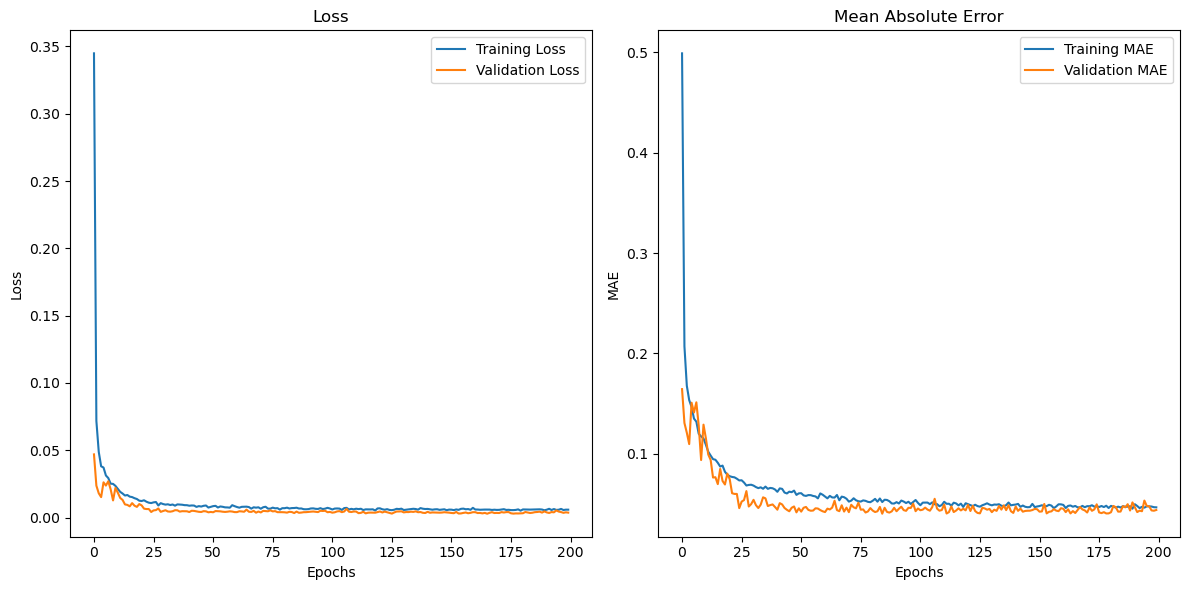

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from qiskit import QuantumCircuit, Aer, execute
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from qiskit.circuit import ParameterVector

# Constants
NUM_QUBITS = 8  
NUM_SAMPLES = 100 

def load_mackey_glass_data(filepath):
    # Load Mackey-Glass series data 
    df = pd.read_excel(filepath)
    return df['t'].values, df['t-taw'].values, df['t+1'].values

def calculate_phase(time):
    """Calculates phase based on time for encoding."""
    return 2 * np.pi * time

def encode_quantum_features(spikes, times, num_qubits=NUM_QUBITS, shots=1024):
    simulator = Aer.get_backend('aer_simulator')
    features = []

    max_spike = max(spikes) if spikes else 1  # Ensure max_spike is never zero
    
    for spike, time in zip(spikes, times):
        qc = QuantumCircuit(num_qubits)
        normalized_amplitude = (spike / max_spike) * np.pi  # Amplitude normalization
        phase = calculate_phase(time)
        for qubit in range(num_qubits):
            qc.u(normalized_amplitude, phase, -phase, qubit)
        
        qc.measure_all()
        job = execute(qc, simulator, shots=shots)
        result = job.result()
        counts = result.get_counts(qc)
        feature_vector = np.array([counts.get(bin(j)[2:].zfill(num_qubits), 0) for j in range(2**num_qubits)])
        features.append(feature_vector / np.sum(feature_vector))
    
    return np.array(features).flatten()

def build_hybrid_model(input_shape):
    quantum_input = Input(shape=(input_shape,), name="quantum_input")
    q = Dense(128, activation='relu')(quantum_input)
    q = Dropout(0.5)(q)
    q = Dense(64, activation='relu')(q)
    q = Dropout(0.5)(q)
    q = Dense(32, activation='relu')(q)
    outputs = Dense(1, activation='linear')(q)
    model = Model(inputs=quantum_input, outputs=outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def main():
    t, t_taw, t_plus_1 = load_mackey_glass_data("C:\\Users\\riakh\\Downloads\\archive (13)\\Mackey-Glass Time Series(taw17).xlsx")

    # Predicting t-taw at t+1 (shifting t-taw right by one step)
    y = np.roll(t_taw, -1)[:-1]  # Shift t-taw to align with t+1 and ignore the last item
    quantum_features = np.array([encode_quantum_features([taw], [time]) for taw, time in zip(t_taw[:-1], t[:-1])])  # Ignore the last item for alignment

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(quantum_features, y, test_size=0.2, random_state=42)

    # Build the hybrid model
    model = build_hybrid_model(quantum_features.shape[1])

    # Train the model
    history = model.fit(X_train, y_train, epochs=200, validation_split=0.1)

    # Evaluate the model
    loss, mae = model.evaluate(X_test, y_test)
    print('\nTest loss:', loss, 'Test MAE:', mae)

    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Mean Absolute Error')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Epoch 1/100
82/82 [==============================] - 1s 4ms/step - loss: 0.1079 - mae: 0.2826 - val_loss: 0.0306 - val_mae: 0.1403 - lr: 0.0010
Epoch 2/100
82/82 [==============================] - 0s 2ms/step - loss: 0.0187 - mae: 0.1061 - val_loss: 0.0119 - val_mae: 0.0879 - lr: 0.0010
Epoch 3/100
82/82 [==============================] - 0s 2ms/step - loss: 0.0118 - mae: 0.0845 - val_loss: 0.0104 - val_mae: 0.0823 - lr: 0.0010
Epoch 4/100
82/82 [==============================] - 0s 2ms/step - loss: 0.0109 - mae: 0.0815 - val_loss: 0.0104 - val_mae: 0.0825 - lr: 0.0010
Epoch 5/100
82/82 [==============================] - 0s 2ms/step - loss: 0.0110 - mae: 0.0818 - val_loss: 0.0105 - val_mae: 0.0828 - lr: 0.0010
Epoch 6/100
82/82 [==============================] - 0s 3ms/step - loss: 0.0110 - mae: 0.0820 - val_loss: 0.0104 - val_mae: 0.0825 - lr: 0.0010
Epoch 7/100
82/82 [==============================] - 0s 2ms/step - loss: 0.0111 - mae: 0.0819 - val_loss: 0.0105 - val_mae: 0.0828 - lr:

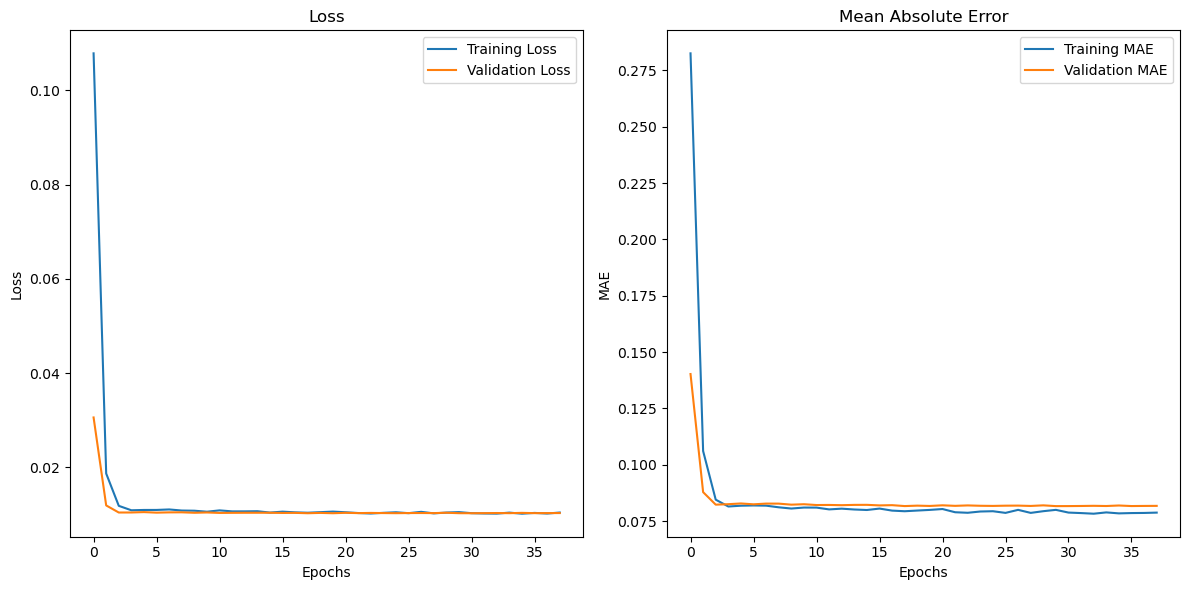

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from qiskit import QuantumCircuit, Aer, execute
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Constants
NUM_QUBITS = 8  # Number of qubits

def load_temperature_data(filepath):
    # Load temperature data
    df = pd.read_csv(filepath, parse_dates=['Date'], dayfirst=True)
    df['Daily minimum temperatures'] = pd.to_numeric(df['Daily minimum temperatures'], errors='coerce')
    df.dropna(inplace=True)  # Remove any rows with NaN values
    return df['Daily minimum temperatures'].values

def calculate_phase(time):
    """Calculates phase based on time for encoding."""
    return 2 * np.pi * time

def encode_quantum_features(amplitudes, times, num_qubits=NUM_QUBITS, shots=1024):
    simulator = Aer.get_backend('aer_simulator')
    feature_matrix = []

    max_amplitude = max(amplitudes) if len(amplitudes) > 0 else 1

    for amplitude, time in zip(amplitudes, times):
        qc = QuantumCircuit(num_qubits)
        normalized_amplitude = (amplitude / max_amplitude) * np.pi
        phase = calculate_phase(time)

        for qubit in range(num_qubits):
            qc.rx(normalized_amplitude, qubit)
            qc.rz(phase, qubit)

        for qubit in range(num_qubits - 1):
            qc.cx(qubit, qubit + 1)

        qc.measure_all()
        job = execute(qc, simulator, shots=shots)
        result = job.result()
        counts = result.get_counts(qc)
        feature_vector = np.array([counts.get(bin(j)[2:].zfill(num_qubits), 0) for j in range(2**num_qubits)])
        feature_matrix.append(feature_vector / np.sum(feature_vector))

    return np.array(feature_matrix)

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def main():
    filepath = "C:\\Users\\riakh\\Downloads\\daily-minimum-temperatures-in-me.csv"  
    temperatures = load_temperature_data(filepath)

    
    scaler = MinMaxScaler()
    temperatures_normalized = scaler.fit_transform(temperatures.reshape(-1, 1)).flatten()
    
    
    times = np.linspace(0, 1, len(temperatures_normalized))

    
    quantum_features = encode_quantum_features(temperatures_normalized, times)
    
    
    X = quantum_features.reshape((quantum_features.shape[0], 1, quantum_features.shape[1]))
    y = temperatures_normalized[1:]  # Next day temperature prediction
    X = X[:-1]  # Align X with shifted y

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Build and train LSTM model
    model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
    history = model.fit(X_train, y_train, epochs=100, validation_split=0.1,
                        callbacks=[early_stopping, reduce_lr])

    # Evaluate the model
    loss, mae = model.evaluate(X_test, y_test)
    print('\nTest loss:', loss, 'Test MAE:', mae)

    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Mean Absolute Error')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()



Epoch 1/100
29/29 [==============================] - 1s 8ms/step - loss: 0.3429 - mae: 0.5429 - val_loss: 0.2699 - val_mae: 0.4709
Epoch 2/100
29/29 [==============================] - 0s 2ms/step - loss: 0.2037 - mae: 0.3951 - val_loss: 0.1327 - val_mae: 0.3025
Epoch 3/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0879 - mae: 0.2326 - val_loss: 0.0470 - val_mae: 0.1763
Epoch 4/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0317 - mae: 0.1453 - val_loss: 0.0171 - val_mae: 0.1134
Epoch 5/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0133 - mae: 0.0933 - val_loss: 0.0056 - val_mae: 0.0606
Epoch 6/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0058 - mae: 0.0578 - val_loss: 0.0018 - val_mae: 0.0289
Epoch 7/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0044 - mae: 0.0486 - val_loss: 0.0010 - val_mae: 0.0220
Epoch 8/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0040 - m

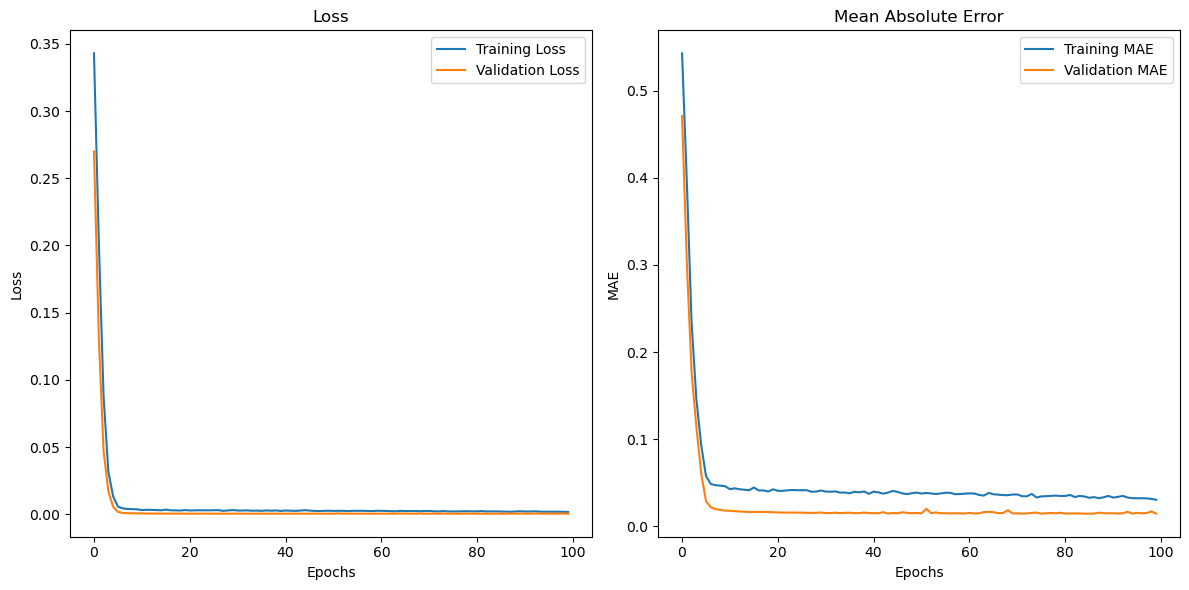

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from qiskit import QuantumCircuit, Aer, execute
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Constants
NUM_QUBITS = 8  

def load_finance_data(filepath):
    
    df = pd.read_excel(filepath, parse_dates=['Date'])

   
    if df['Close*'].dtype == 'object':
        
        df['Close*'] = pd.to_numeric(df['Close*'].str.replace(',', ''), errors='coerce')
    else:
      
        df['Close*'] = pd.to_numeric(df['Close*'], errors='coerce')

    df.dropna(subset=['Close*'], inplace=True)  
    return df['Close*'].values


def calculate_phase(time):
    """Calculates phase based on time for encoding."""
    return 2 * np.pi * time

def encode_quantum_features(values, times, num_qubits=NUM_QUBITS, shots=1024):
    simulator = Aer.get_backend('aer_simulator')
    feature_matrix = []

    max_value = max(values) if len(values) > 0 else 1

    for value, time in zip(values, times):
        qc = QuantumCircuit(num_qubits)
        normalized_value = (value / max_value) * np.pi
        phase = calculate_phase(time)

        for qubit in range(num_qubits):
            qc.rx(normalized_value, qubit)  
            qc.rz(phase, qubit)
        
        
        for qubit in range(num_qubits - 1):
            qc.cx(qubit, qubit + 1)

        qc.measure_all()
        job = execute(qc, simulator, shots=shots)
        result = job.result()
        counts = result.get_counts(qc)
        feature_vector = np.array([counts.get(bin(j)[2:].zfill(num_qubits), 0) for j in range(2**num_qubits)])
        feature_matrix.append(feature_vector / np.sum(feature_vector)) 

    return np.array(feature_matrix)

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def main():
    filepath = "C:\\Users\\riakh\\Downloads\\archive (14)\\yahoo_data.xlsx"  
    close_values = load_finance_data(filepath)

    
    scaler = MinMaxScaler()
    close_values_normalized = scaler.fit_transform(close_values.reshape(-1, 1)).flatten()
    
    # Generate time points for phase encoding
    times = np.linspace(0, 1, len(close_values_normalized))

    # Generate quantum features
    quantum_features = encode_quantum_features(close_values_normalized, times)
    
   
    X = quantum_features.reshape((quantum_features.shape[0], 1, quantum_features.shape[1]))
    y = close_values_normalized[1:]  # Next day close value prediction
    X = X[:-1]  # Align X with shifted y

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    
    model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
    history = model.fit(X_train, y_train, epochs=100, validation_split=0.1)

    # Evaluate the model
    loss, mae = model.evaluate(X_test, y_test)
    print('\nTest loss:', loss, 'Test MAE:', mae)

    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Mean Absolute Error')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
